In [1]:
import advanced
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Some auxiliary functions

In [2]:
def write_frames(framelist, prepend = "troubled_", filename="project_video.mp4"):
    """Writes specific frames from the project video. Frames are specified as indices in framelist."""
    vidcap = cv2.VideoCapture(filename)
    success, image = vidcap.read()
    count = 0
    success = True
    while success:
        success, image = vidcap.read()
        if (count + 3) in framelist:
            cv2.imwrite(prepend + str(count + 3) + ".jpg", image)     # save frame as JPEG file
        count += 1

In [3]:
def side_by_side(img1, img2, caption1, caption2):
    """Shows two images side-by-side with captions"""
    plt_fig = plt.figure(figsize=(20,10))
    sub_plot = plt_fig.add_subplot(1, 2, 1)
    sub_plot.set_title(caption1)
    sub_plot.axis('off')
    plt.imshow(img1)
    sub_plot = plt_fig.add_subplot(1, 2, 2)
    sub_plot.set_title(caption2)
    sub_plot.axis('off')
    plt.imshow(img2)

## Camera calibration and distortion correction

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        print("OK")
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

./camera_cal/calibration1.jpg
./camera_cal/calibration10.jpg
OK
./camera_cal/calibration11.jpg
OK
./camera_cal/calibration12.jpg
OK
./camera_cal/calibration13.jpg
OK
./camera_cal/calibration14.jpg
OK
./camera_cal/calibration15.jpg
OK
./camera_cal/calibration16.jpg
OK
./camera_cal/calibration17.jpg
OK
./camera_cal/calibration18.jpg
OK
./camera_cal/calibration19.jpg
OK
./camera_cal/calibration2.jpg
OK
./camera_cal/calibration20.jpg
OK
./camera_cal/calibration3.jpg
OK
./camera_cal/calibration4.jpg
./camera_cal/calibration5.jpg
./camera_cal/calibration6.jpg
OK
./camera_cal/calibration7.jpg
OK
./camera_cal/calibration8.jpg
OK
./camera_cal/calibration9.jpg
OK


Storing the calibration info and testing loading the stored calibration info

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

with open('calibration_info', 'wb') as handle:
    pickle.dump((ret, mtx, dist, rvecs, tvecs), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('calibration_info', 'rb') as handle:
    (ret, mtx, dist, rvecs, tvecs) = pickle.load(handle)

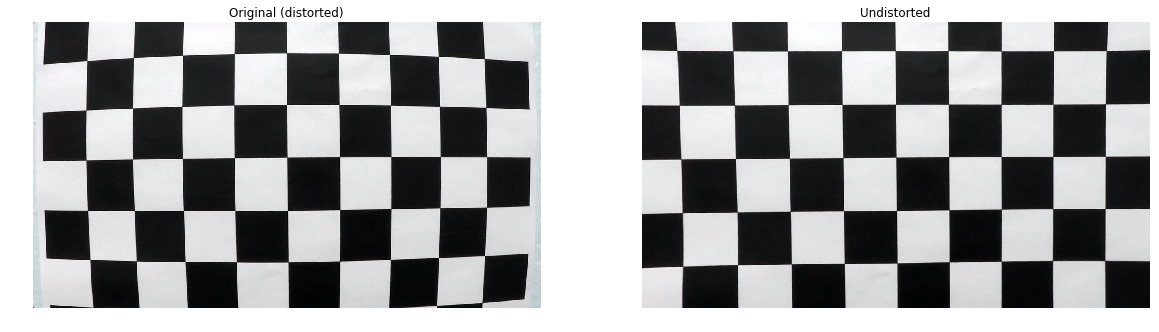

In [7]:
img = cv2.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
side_by_side(img, undist, "Original (distorted)", "Undistorted")

Create an example of the un-distortion.

/Users/sdegryze/repos/CarND-Advanced-Lane-Lines/test_images/trouble_2.jpg


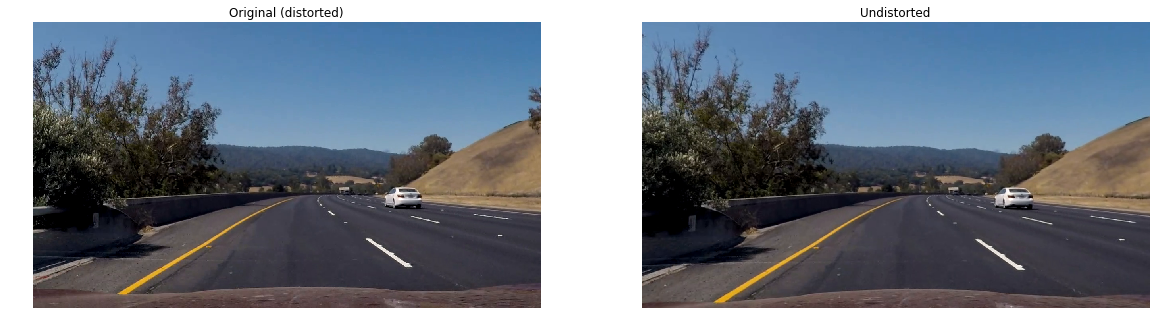

In [8]:
image_paths = glob.glob("/Users/sdegryze/repos/CarND-Advanced-Lane-Lines/test_images/*.jpg")
idx = 12
plt.figure(figsize=(17, 22))
print(image_paths[idx])
img = pltimg.imread(image_paths[idx])
undist = cv2.undistort(img, mtx, dist, None, mtx)
side_by_side(img, undist, "Original (distorted)", "Undistorted")

## Thresholding

In [9]:
def threshold(input_image, l_threshold = 220,  h_min_threshold = 18, h_max_threshold = 22,
              yellow_s_channel_min = 150, yellow_s_channel_max = 255, yellow_l_channel_max=200,
              yellow_l_channel_min=100):
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2HLS)
    h_channel = hls_image[:,:,0]
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]

    yellow_binary = np.zeros_like(h_channel)
    yellow_binary[(((h_channel >= h_min_threshold) &
                (h_channel <= h_max_threshold) &
                (s_channel >= yellow_s_channel_min) &
                (s_channel <= yellow_s_channel_max) &   
                (l_channel <= yellow_l_channel_max) &
                (l_channel >= yellow_l_channel_min)))] = 1

    white_binary = np.zeros_like(h_channel)
    white_binary[(l_channel >= l_threshold)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(h_channel)
    combined_binary[(white_binary == 1) | (yellow_binary == 1)] = 1

    zeros = np.zeros_like(h_channel)
    ones = np.ones_like(h_channel) * 255

    r_color = np.maximum(white_binary * 255, yellow_binary * 255)
    b_color = np.maximum(white_binary * 255, yellow_binary * 100)
    color_binary = np.dstack(( r_color, r_color, b_color))

    return combined_binary, color_binary

/Users/sdegryze/repos/CarND-Advanced-Lane-Lines/test_images/troubled_635.jpg


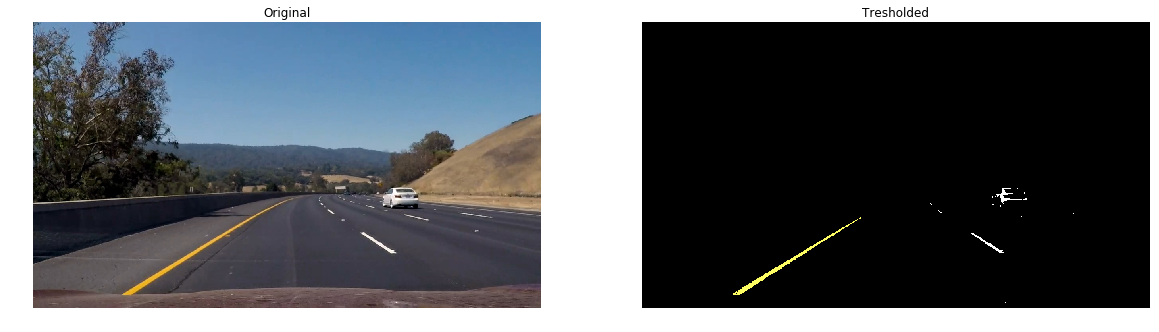

In [10]:
image_paths = glob.glob("/Users/sdegryze/repos/CarND-Advanced-Lane-Lines/test_images/*.jpg")
idx = 29
plt.figure(figsize=(17, 22))
print(image_paths[idx])
image = pltimg.imread(image_paths[idx])
binary = threshold(image)[1]
side_by_side(image, binary, "Original", "Tresholded")

In [11]:
output = 'binary_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

binary_output_clip = clip.fl_image(lambda image:threshold(image)[1])
%time binary_output_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video binary_video_output.mp4
[MoviePy] Writing video binary_video_output.mp4


100%|█████████▉| 1260/1261 [00:22<00:00, 55.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: binary_video_output.mp4 

CPU times: user 27.9 s, sys: 4.33 s, total: 32.2 s
Wall time: 22.8 s


## Perspective transform

(-0.5, 1279.5, 719.5, -0.5)

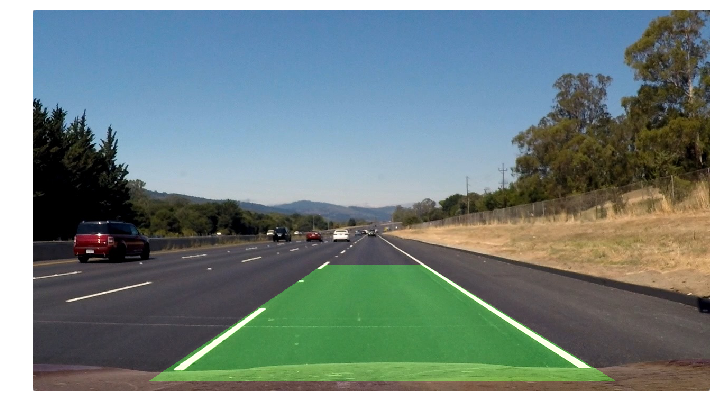

In [12]:
image_paths = glob.glob("/Users/sdegryze/repos/CarND-Advanced-Lane-Lines/test_images/*.jpg")
img = pltimg.imread(image_paths[1])

white = np.zeros_like(img)
src = np.array([[220, img.shape[0] - 20],
                  [1100, img.shape[0] - 20],
                  [740, img.shape[0] // 1.75 + 70],
                  [548, img.shape[0] // 1.75 + 70]], np.int32)
dst = np.array([[390, img.shape[1] - 20],
                  [925, img.shape[1] - 20],
                  [925, img.shape[1] // 1.75 + 70],
                  [390, img.shape[1] // 1.75 + 70]], np.float32)
cv2.fillConvexPoly(white, src, (0,255, 0))
result = cv2.addWeighted(img, 1, white, 0.3, 0)

plt.figure(figsize=(15, 7))
plt.imshow(result)
plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

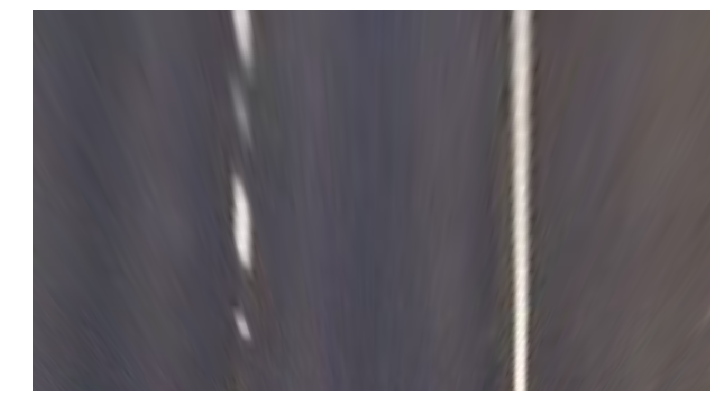

In [13]:
img = pltimg.imread(image_paths[1])
img_size = (img.shape[1], img.shape[0])
M = cv2.getPerspectiveTransform(src.astype(np.float32), dst.astype(np.float32))
Minv = cv2.getPerspectiveTransform(dst.astype(np.float32), src.astype(np.float32))
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)


plt.figure(figsize=(15, 7))
plt.imshow(warped)
plt.axis('off')

## Image pipeline containing lane detection

In [22]:
class LaneFinder():

    def __init__(self):
        with open('calibration_info', 'rb') as handle:
            calibration_info = pickle.load(handle)
        self.distortion_data = calibration_info
        image_paths = glob.glob("/Users/sdegryze/repos/CarND-Advanced-Lane-Lines/test_images/*.jpg")
        img = pltimg.imread(image_paths[1])
        self.img_size = (img.shape[1], img.shape[0])

        src = np.array([[220, self.img_size[1] - 20],
                  [1100, self.img_size[1] - 20],
                  [740, self.img_size[1] // 1.75 + 70],
                  [548, self.img_size[1] // 1.75 + 70]], np.float32)
        dst = np.array([[390, self.img_size[1] - 20],
                  [925, self.img_size[1] - 20],
                  [925, self.img_size[1] // 1.75 + 70],
                  [390, self.img_size[1] // 1.75 + 70]], np.float32)
        
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        self.left_fit_0, self.left_fit_1, self.left_fit_2 = [], [], []
        self.right_fit_0, self.right_fit_1, self.right_fit_2 = [], [], []
        self.last_left_fit, self.last_right_fit = None, None
        
        self.right_was_copied = 0
        self.left_was_copied = 0
        self.frame_nr = 0
    
    def undistort(self, img):
        ret, mtx, dist, rvecs, tvecs = self.distortion_data
        return cv2.undistort(img, mtx, dist, None, mtx)
                    
    def threshold(self, input_image, l_threshold = 220,  h_min_threshold = 18, h_max_threshold = 22,
                  yellow_s_channel_min = 150, yellow_s_channel_max = 255, yellow_l_channel_max=200,
                  yellow_l_channel_min=100):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2HLS)
        h_channel = hls_image[:,:,0]
        l_channel = hls_image[:,:,1]
        s_channel = hls_image[:,:,2]

        yellow_binary = np.zeros_like(h_channel)
        yellow_binary[(((h_channel >= h_min_threshold) &
                    (h_channel <= h_max_threshold) &
                    (s_channel >= yellow_s_channel_min) &
                    (s_channel <= yellow_s_channel_max) &   
                    (l_channel <= yellow_l_channel_max) &
                    (l_channel >= yellow_l_channel_min)))] = 1
        
        white_binary = np.zeros_like(h_channel)
        white_binary[(l_channel >= l_threshold)] = 1
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(h_channel)
        combined_binary[(white_binary == 1) | (yellow_binary == 1)] = 1
        return combined_binary
    
    def warp(self, input_image):
        output_image = cv2.warpPerspective(input_image, self.M, self.img_size, flags=cv2.INTER_LINEAR)
        return output_image
    
    def unwarp(self, input_image):
        output_image = cv2.warpPerspective(input_image, self.Minv, self.img_size, flags=cv2.INTER_LINEAR)
        return output_image
    
    def get_lane_pixels_sliding(self, input_image):

        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(input_image[input_image.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(input_image.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = input_image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = input_image.shape[0] - (window+1)*window_height
            win_y_high = input_image.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        return leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds
    
    def warp_and_find_lanes(self, input_image):
        input_image = input_image[:, :, 0:3]
        binary = self.threshold(input_image)
        binary_warped = self.warp(binary)
        leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds = self.get_lane_pixels_sliding(binary_warped)
            
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        margin = 40
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        window_img = np.zeros_like(input_image)
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        out_img[ploty.astype(np.int), left_fitx.astype(np.int)] = [255, 255, 255]
        out_img[ploty.astype(np.int), right_fitx.astype(np.int)] = [255, 255, 255]
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        return(result)
    
    def get_lane_pixels_window(self, input_image, last_left_fit, last_right_fit):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = input_image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 10
        left_lane_inds = ((nonzerox > (last_left_fit[0]*(nonzeroy**2) + last_left_fit[1]*nonzeroy + last_left_fit[2] - margin)) &
                          (nonzerox < (last_left_fit[0]*(nonzeroy**2) + last_left_fit[1]*nonzeroy + last_left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (last_right_fit[0]*(nonzeroy**2) + last_right_fit[1]*nonzeroy + last_right_fit[2] - margin)) &
                           (nonzerox < (last_right_fit[0]*(nonzeroy**2) + last_right_fit[1]*nonzeroy + last_right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        return leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds
                               

    def detect_lanes(self, input_image):
        input_image = input_image[:, :, 0:3]
        binary = self.threshold(input_image)
        binary_warped = self.warp(binary)
        if self.last_left_fit is None:
            leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds = self.get_lane_pixels_sliding(binary_warped)
        else:
            leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds = self.get_lane_pixels_window(binary_warped, self.last_left_fit, self.last_right_fit)
        
            if leftx.size < 1000:
                leftx, lefty, dummy1, dummy2, left_lane_inds, dummy3 = self.get_lane_pixels_sliding(binary_warped)
            
            if rightx.size < 1000:
                dummy1, dummy2, rightx, righty, dummy3, right_lane_inds = self.get_lane_pixels_sliding(binary_warped)
        
        right_fit = np.polyfit(righty, rightx, 2)
        left_fit = np.polyfit(lefty, leftx, 2)
        text = ""

        if not(self.last_left_fit is None):
            left_diff_0 = abs(left_fit[0] - self.last_left_fit[0])
            left_diff_1 = abs(left_fit[1] - self.last_left_fit[1])
            left_diff_2 = abs(left_fit[2] - self.last_left_fit[2])
            right_diff_0 = abs(right_fit[0] - self.last_right_fit[0])
            right_diff_1 = abs(right_fit[1] - self.last_right_fit[1])
            right_diff_2 = abs(right_fit[2] - self.last_right_fit[2])

            if (len(self.left_fit_0) > 2):
                
                # smoothing: if the difference to the previous parameter is too large,
                # use last frame's parameters
                if (((left_diff_0 > 0.0002) or 
                     (left_diff_1 > 0.2) or
                     (left_diff_2 > 40) or
                     (left_fit[0] > 0.001))
                    # but do this only for maximally 2 frames!
                    and self.left_was_copied < 2):
                    left_fit = self.last_left_fit.copy()
                    self.left_was_copied += 1
                else:
                    self.left_was_copied = 0

                if (((right_diff_0 > 0.0004) or
                     (right_diff_1 > 0.5) or
                     (right_diff_2 > 50))
                    and self.right_was_copied < 2):
                    right_fit = self.last_right_fit.copy()
                    self.right_was_copied += 1
                else:
                    self.right_was_copied = 0
        
        self.frame_nr += 1
        
        self.last_left_fit = left_fit.copy()
        self.last_right_fit = right_fit.copy()
        
        self.left_fit_0.append(left_fit[0])
        self.left_fit_1.append(left_fit[1])
        self.left_fit_2.append(left_fit[2])
        self.right_fit_0.append(right_fit[0])
        self.right_fit_1.append(right_fit[1])
        self.right_fit_2.append(right_fit[2])

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Calculate curvature
        ym_per_pix = 30/len(ploty) # meters per pixel in y dimension
        xm_per_pix = 3.7/520 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        y_eval = np.max(lefty)
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        
        camera_position = 1280/2
        lane_center = (right_fitx[719] + left_fitx[719])/2
        center_offset_pixels = camera_position - lane_center
        center_offset_m = center_offset_pixels * xm_per_pix
        text = "frame {:d}; left={:.1f}m; right={:.1f}m; offset={:.2f}m".format(self.frame_nr,
                                                                                left_curverad,
                                                                                right_curverad,
                                                                                center_offset_m)

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        margin = 10
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        cv2.fillPoly(color_warp, np.int_([left_line_pts]), (255, 0, 0))
        cv2.fillPoly(color_warp, np.int_([right_line_pts]), (0, 0, 255))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (input_image.shape[1], input_image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(input_image, 1, newwarp, 0.3, 0)
        cv2.putText(result, text, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, 255, 2)
        
        return(result)

Visualizing the polynomial fit in the perspective-corrected images

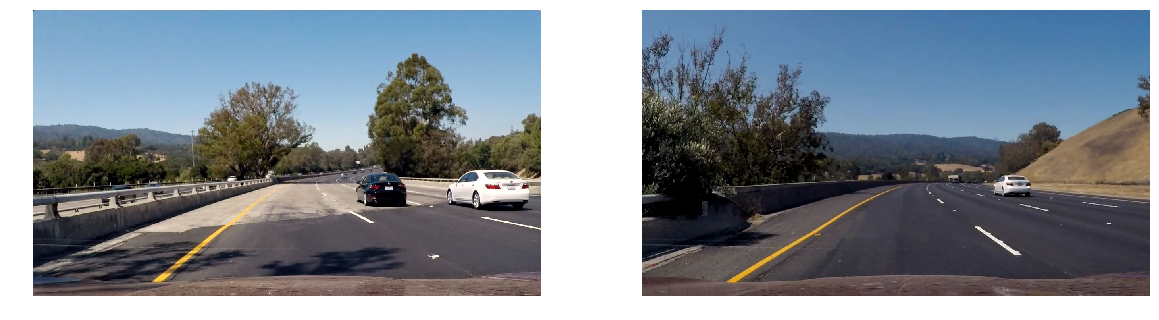

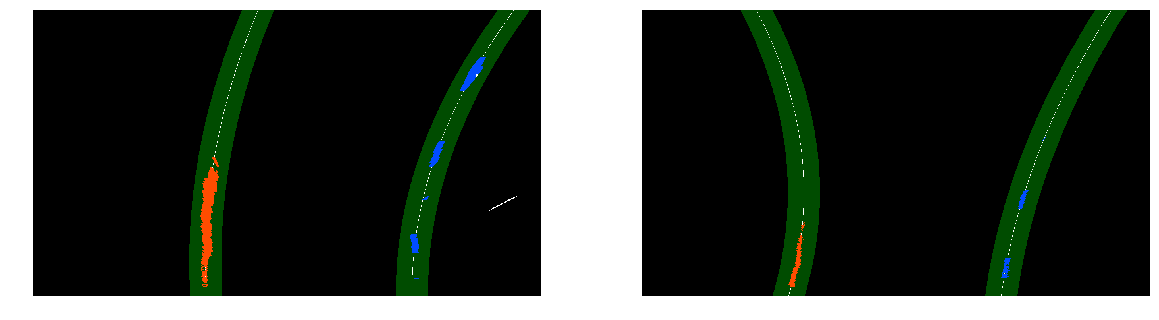

In [15]:
image_paths = glob.glob("/Users/sdegryze/repos/CarND-Advanced-Lane-Lines/test_images/*.jpg")
img1 = pltimg.imread(image_paths[5])
img2 = pltimg.imread(image_paths[12])
side_by_side(img1, img2, "", "")

lf = LaneFinder()
img1_proc = lf.warp_and_find_lanes(img1)
lf = LaneFinder()
img2_proc = lf.warp_and_find_lanes(img2)
side_by_side(img1_proc, img2_proc, "", "")

To be able to calculate the curvatures and distance from center, we need to know the number of pixels in between the two lanes. I plotted two dots on the lines to get the x positions of the lanes, so I can subtract the x positions to get the lane width in pixels.

520


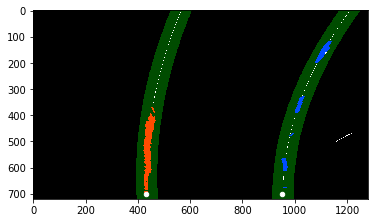

In [16]:
plt.imshow(img1_proc)
plt.scatter([430, 950], [700, 700], s=20, color='white')
print(950-430)

back-projecting the polynomial fits to the original perspective

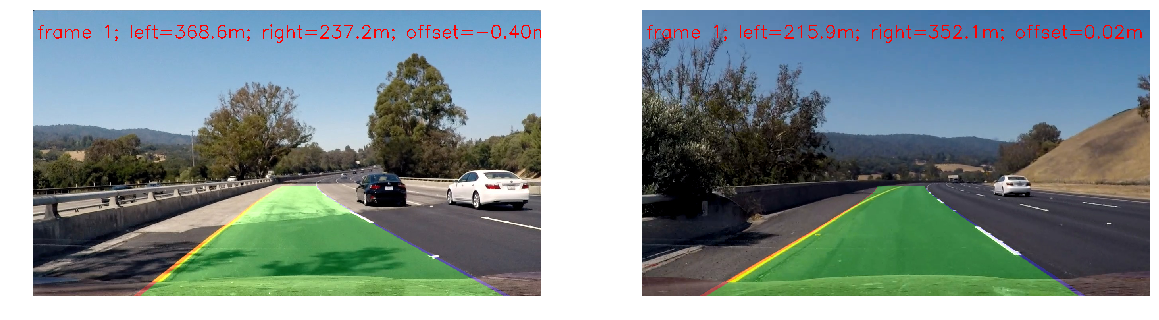

In [23]:
image_paths = glob.glob("/Users/sdegryze/repos/CarND-Advanced-Lane-Lines/test_images/*.jpg")
img1 = pltimg.imread(image_paths[5])
img2 = pltimg.imread(image_paths[12])

lf = LaneFinder()
img1_proc = lf.detect_lanes(img1)
lf = LaneFinder()
img2_proc = lf.detect_lanes(img2)
side_by_side(img1_proc, img2_proc, "", "")

Creating a video of the lane finding

In [18]:
lf = LaneFinder()
output = 'smoothed_project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

smoothed_output_clip = clip.fl_image(lf.detect_lanes)
%time smoothed_output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video smoothed_project_video_output.mp4
[MoviePy] Writing video smoothed_project_video_output.mp4


100%|█████████▉| 1260/1261 [01:00<00:00, 21.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: smoothed_project_video_output.mp4 

CPU times: user 1min 40s, sys: 9.47 s, total: 1min 50s
Wall time: 1min


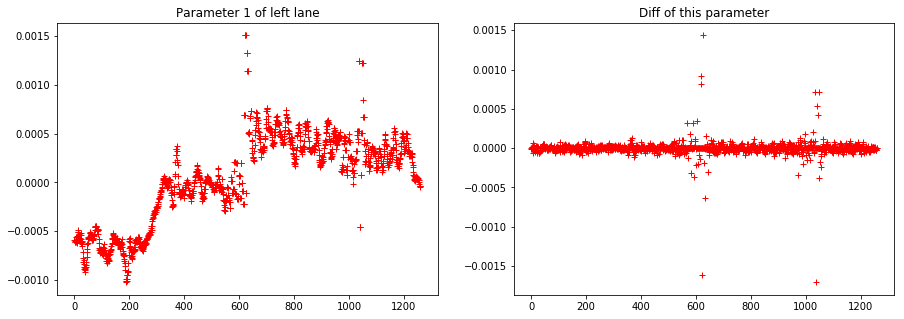

In [19]:
plt_fig = plt.figure(figsize=(15, 5))
sub_plot = plt_fig.add_subplot(1, 2, 1)
sub_plot.set_title("Parameter 1 of left lane")
plt.plot(lf.left_fit_0, 'r+')
sub_plot = plt_fig.add_subplot(1, 2, 2)
sub_plot.set_title("Diff of this parameter")
plt.plot(np.diff(lf.left_fit_0), 'r+')  

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))